In [2]:
# !pip install numpy pandas matplotlib opencv-python scikit-learn tensorflow
# !pip install tqdm


In [3]:


import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical


In [4]:
base_path = "../pollen_dataset"
images_path = os.path.join(base_path, "images")
bbox_csv = os.path.join(base_path, "bboxes.csv")
class_map_csv = os.path.join(base_path, "class_map.csv")
# Load CSVs
bboxes_df = pd.read_csv(bbox_csv)
class_map_df = pd.read_csv(class_map_csv)

# Clean column names if needed
bboxes_df.columns = ["filename", "xmin", "ymin", "xmax", "ymax", "class_name"]


In [5]:
X, Y = [], []
for i, row in tqdm(bboxes_df.iterrows(), total=len(bboxes_df)):
    image_file = os.path.join(images_path, row["filename"])
    if not os.path.exists(image_file):
        continue

    img = cv2.imread(image_file)
    if img is None:
        continue

    x1, y1, x2, y2 = int(row["xmin"]), int(row["ymin"]), int(row["xmax"]), int(row["ymax"])
    cropped_img = img[y1:y2, x1:x2]
    try:
        resized = cv2.resize(cropped_img, (128, 128))
    except:
        continue
    normalized = resized / 255.0

    X.append(normalized)
    Y.append(row["class_name"])

X = np.array(X)
Y = np.array(Y)


100%|██████████| 7743/7743 [01:01<00:00, 125.03it/s]


In [6]:
import pickle

In [7]:
le = LabelEncoder()
Y_le = le.fit_transform(Y)

with open("labelencoder.pkl","wb") as f:
    pickle.dump(le,f)

Y_cat = to_categorical(Y_le, len(le.classes_))

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_cat, test_size=0.2, stratify=Y_le, random_state=42)

print(f"Images in test set (per class): {np.sum(Y_test, axis=0)}")


Images in test set (per class): [ 94.  95.  71. 133.  43.  64.  73.  43.  15. 132.  68. 232.  47.  24.
  46.  63.  46.  43.  54. 163.]


In [8]:
model = Sequential([
    Conv2D(16, 3, activation='relu', padding='same', input_shape=X_train[0].shape),
    MaxPooling2D(2),
    Conv2D(32, 2, activation='relu', padding='same'),
    MaxPooling2D(2),
    Conv2D(64, 2, activation='relu', padding='same'),
    MaxPooling2D(2),
    Conv2D(128, 2, activation='relu', padding='same'),
    MaxPooling2D(2),
    Flatten(),
    Dropout(0.2),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(150, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        75,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         3,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,350 (16.09 MB)

 Trainable params: 4,218,350 (16.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(X_train)

model_path="cnn.weights.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20),
    ModelCheckpoint(model_path, save_best_only=True, save_weights_only=True)
]

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=4),
    epochs=500,
    validation_data=(X_train, Y_train),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1549/1549 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.2311 - loss: 2.5422 - val_accuracy: 0.4766 - val_loss: 1.6374
Epoch 2/500
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.4687 - loss: 1.6101 - val_accuracy: 0.6881 - val_loss: 0.9807
Epoch 3/500
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.6389 - loss: 1.0962 - val_accuracy: 0.7612 - val_loss: 0.7028
Epoch 4/500
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.7338 - loss: 0.8105 - val_accuracy: 0.8030 - val_loss: 0.6042
Epoch 5/500
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.7824 - loss: 0.6772 - val_accuracy: 0.8534 - val_loss: 0.4090
Epoch 6/500
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.7951 - loss: 0.6335 - val_accuracy: 0.8660 - val_loss: 0.4169
Epoch 7/500
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.8198 - loss: 0.5759 - val_accuracy: 0.8618 - val_loss: 0.3692
Epoch 8/500
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.8280 - los

In [11]:
model.load_weights(model_path)
score = model.evaluate(X_test, Y_test)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

y_pred = model.predict(X_test).argmax(axis=1)
y_true = Y_test.argmax(axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9662 - loss: 0.1789
Test Loss: 0.2078019082546234
Test Accuracy: 0.9606197476387024
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[[ 80   1   1   0   0   0   0   3   0   1   0   0   0   0   0   4   0   0
    0   4]
 [  0  93   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   1]
 [  0   0  70   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   0   0 132   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0  42   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0  60   1   0   0   1   0   0   0   0   0   0   0   0
    0   2]
 [  0   0   0   0   2   0  68   0   0   2   1   0   0   0   0   0   0   0
    0   0]
 [  1   0   0   0   0   0   0  42   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   3   0   0   0   0  12   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   1   0   0   0   0   0 129   0   0   0   0

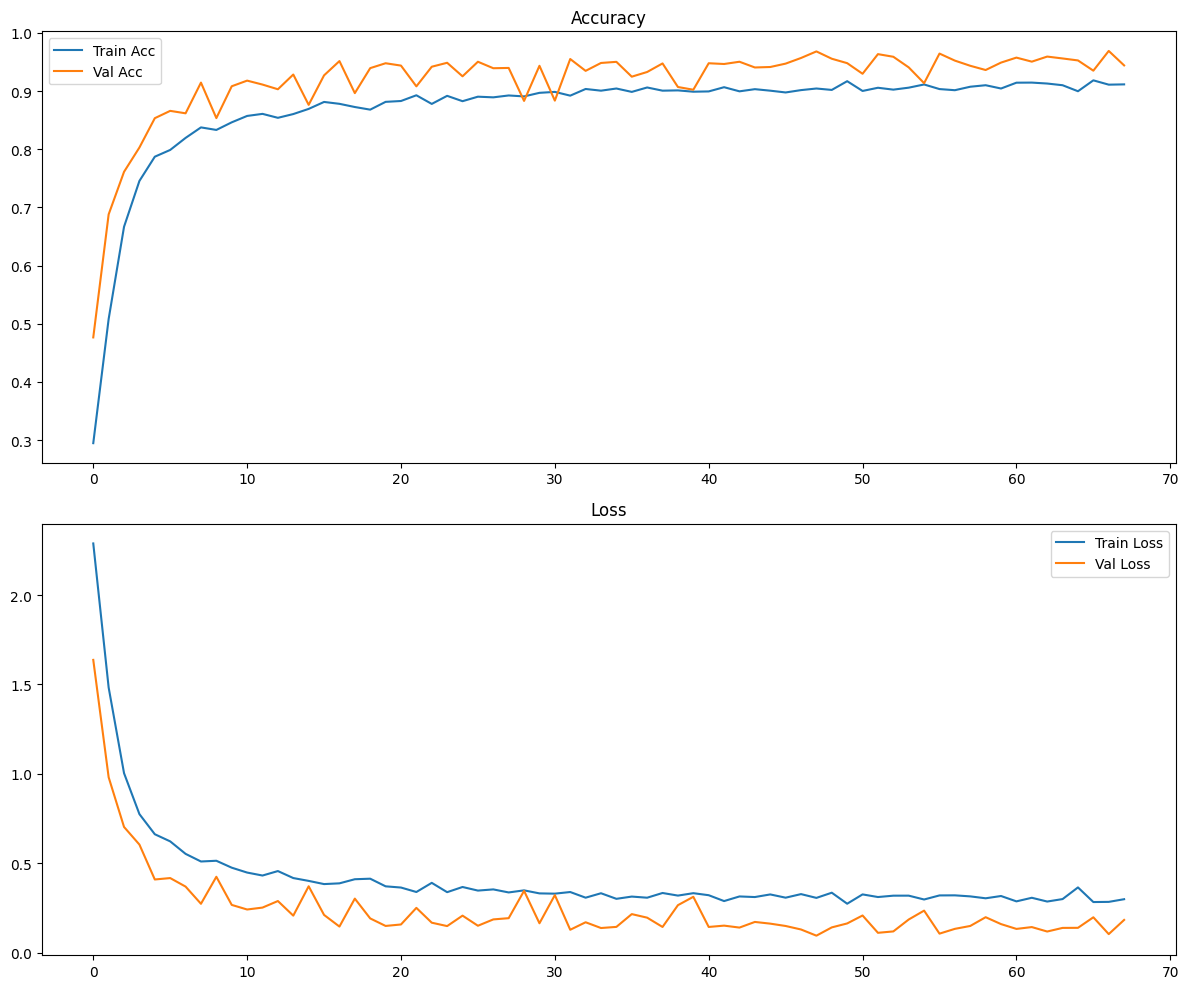

In [12]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    axs[0].plot(epochs, acc, label='Train Acc')
    axs[0].plot(epochs, val_acc, label='Val Acc')
    axs[0].legend()
    axs[0].set_title("Accuracy")

    axs[1].plot(epochs, loss, label='Train Loss')
    axs[1].plot(epochs, val_loss, label='Val Loss')
    axs[1].legend()
    axs[1].set_title("Loss")

    plt.tight_layout()
    plt.show()

plot_metrics(history)


In [13]:
def predict_image_class(model, img_path, target_size=(128, 128)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    input_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(input_array, verbose=0)
    class_idx = np.argmax(prediction)
    class_name = le.classes_[class_idx]
    print(f"Predicted: {class_name}")


In [ ]:
model.save("pollen_model.keras")


In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

# Class Labels
class_names = le.classes_.tolist()

# Prediction function for external image (must be preprocessed like training data)
def predict_image_class(model, img_path, bbox=None, target_size=(128, 128)):
    # Load the original image
    img = cv2.imread(img_path)

    if img is None:
        print("❌ Image not found:", img_path)
        return

    if bbox:
        x1, y1, x2, y2 = bbox
        img = img[y1:y2, x1:x2]

    # Resize and normalize
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    # Predict
    prediction = model.predict(img_input, verbose=0)
    predicted_index = np.argmax(prediction)
    predicted_label = class_names[predicted_index]

    # Output
    print(f"📌 Predicted class index: {predicted_index}")
    print(f"🏷️ Predicted class label: {predicted_label}")

In [16]:
# Test a single random image from the dataset
sample = bboxes_df.sample(1).iloc[0]
img_file = os.path.join(images_path, sample["filename"])
bbox = [int(sample["xmin"]), int(sample["ymin"]), int(sample["xmax"]), int(sample["ymax"])]

print(f"🖼️ Testing image: {sample['filename']}")
predict_image_class(model, img_file, bbox=bbox)

🖼️ Testing image: 29_jpg.rf.19a23e1b8e9c5ff7d7ec427a1e636cb0.jpg
📌 Predicted class index: 13
🏷️ Predicted class label: mugwort


In [17]:
for class_name in bboxes_df["class_name"].unique():
    class_rows = bboxes_df[bboxes_df["class_name"] == class_name]
    sample = class_rows.sample(1).iloc[0]

    img_path = os.path.join(images_path, sample["filename"])
    bbox = [int(sample["xmin"]), int(sample["ymin"]), int(sample["xmax"]), int(sample["ymax"])]

    print(f"\n🎯 True label: {class_name} | Image: {sample['filename']}")
    predict_image_class(model, img_path, bbox=bbox)


🎯 True label: hill_mustard | Image: --------------------100_jpg.rf.25cdc6b6ed08497378712e4dbe21251d.jpg
📌 Predicted class index: 9
🏷️ Predicted class label: hill_mustard

🎯 True label: fireweed | Image: ---------------------200_jpg.rf.c4faed43ca2124dd631ad305f6533784.jpg
📌 Predicted class index: 6
🏷️ Predicted class label: fireweed

🎯 True label: plantain | Image: 108_jpg.rf.587f24add52989352ec7c0c737095be4.jpg
📌 Predicted class index: 17
🏷️ Predicted class label: plantain

🎯 True label: linden | Image: 61_jpg.rf.254c989ac4e9049db5c7090484b79917.jpg
📌 Predicted class index: 10
🏷️ Predicted class label: linden

🎯 True label: clover | Image: ----------------4_jpg.rf.459066ca75590afe87e2c90e8bc303de.jpg
📌 Predicted class index: 5
🏷️ Predicted class label: clover

🎯 True label: pigweed | Image: 102_jpg.rf.37913e2870dbd914b297b718becd13cb.jpg
📌 Predicted class index: 15
🏷️ Predicted class label: pigweed

🎯 True label: willow | Image: ---------4_jpg.rf.33c6e1698d9d81e168bfeb0573fea78e.jpg
📌